# Data

In [148]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [149]:
image_dir = '/kaggle/input/suim-dataset/train_val/train_val/images'
mask_dir = '/kaggle/input/suim-dataset/train_val/train_val/masks'

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

image_files = [os.path.join(image_dir, f) for f in image_files]
mask_files = [os.path.join(mask_dir, f) for f in mask_files]

train_images, val_images, train_masks, val_masks = train_test_split(image_files, mask_files, test_size=0.1, random_state=42)

In [150]:
test_image_dir = '/kaggle/input/suim-dataset/test/TEST/images'
test_mask_dir = '/kaggle/input/suim-dataset/test/TEST/masks'

test_image_files = sorted(os.listdir(test_image_dir))
test_mask_files = sorted(os.listdir(test_mask_dir))

test_masks = [os.path.join(test_mask_dir, f) for f in test_mask_files if os.path.join(test_mask_dir, f).endswith('.bmp')]
test_images = [os.path.join(test_image_dir, f)[:-4] + '.jpg' for f in test_mask_files if os.path.join(test_mask_dir, f).endswith('.bmp')]

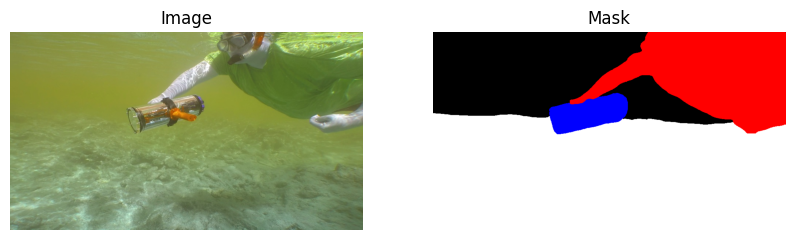

In [151]:
def display_image_and_mask(images, masks):
    image = images[0]
    mask = masks[0]
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(cv2.imread(image))
    axs[0].set_title("Image")
    axs[0].axis('off')
    
    axs[1].imshow(cv2.imread(mask))
    axs[1].set_title("Mask")
    axs[1].axis('off')
    
    plt.show()
    
display_image_and_mask(test_images, test_masks)

## Data loader

In [152]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import albumentations as A
from skimage.color import rgb2gray

In [153]:
class ImageMaskGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, image_size=(256, 256), shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augmentation = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        image_filenames_temp = [self.image_filenames[k] for k in indexes]
        mask_filenames_temp = [self.mask_filenames[k] for k in indexes]
        
        X, y = self.__data_generation(image_filenames_temp, mask_filenames_temp)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def one_hot_mask(self, mask):
        final_mask = np.zeros((self.image_size[0], self.image_size[1], 8))
        for i in range(self.image_size[0]):
            for j in range(self.image_size[1]):
                if mask[i][j][0] == 1:
                    if mask[i][j][1] == 1:
                        if mask[i][j][2] == 1:
                            final_mask[i][j][0] = 1
                        else:
                            final_mask[i][j][1] = 1
                    else:
                        if mask[i][j][2] == 1:
                            final_mask[i][j][2] = 1
                        else:
                            final_mask[i][j][3] = 1         
                else:
                    if mask[i][j][1] == 1:
                        if mask[i][j][2] == 1:
                            final_mask[i][j][4] = 1
                        else:
                            final_mask[i][j][5] = 1
                    else:
                        if mask[i][j][2] == 1:
                            final_mask[i][j][6] = 1
                        else:
                            final_mask[i][j][7] = 1
        return final_mask
        
    
    def __data_generation(self, batch_image_filenames, batch_mask_filenames):
        X = np.empty((self.batch_size, *self.image_size, 3))
        y = np.empty((self.batch_size, *self.image_size, 8))

        for i, (img_path, mask_path) in enumerate(zip(batch_image_filenames, batch_mask_filenames)):
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path)

            image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

            if self.augmentation:
                augmented = self.augmentation(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            # Normalize
            image = image / 255.0
            mask = mask / 255.0
            
            mask = np.where(mask > 0.5, 1, 0)
            
            mask = self.one_hot_mask(mask)

            X[i,] = image
            y[i,] = mask

        return X, y

In [154]:
batch_size = 4
image_size = (128, 128)

transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Transpose(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5)
        ], additional_targets={'mask': 'mask'})

# Generators
train_generator = ImageMaskGenerator(train_images, train_masks, batch_size=batch_size, image_size=image_size, augment=transform)
val_generator = ImageMaskGenerator(val_images, val_masks, batch_size=batch_size, image_size=image_size)
test_generator = ImageMaskGenerator(test_images, test_masks, batch_size=batch_size, image_size=image_size)

# Model

## U-net

In [155]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy

In [71]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    conv = layers.Conv2D(8, (1, 1))(c9)
    outputs = layers.Softmax(axis=-1)(conv)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [72]:
def lovasz_grad(gt_sorted):
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted, axis=0)
    union = gts + tf.cumsum(1 - gt_sorted, axis=0)
    jaccard = 1.0 - intersection / union
    jaccard = tf.concat([jaccard[:1], jaccard[1:] - jaccard[:-1]], axis=0)
    return jaccard

def lovasz_softmax_flat(probas, labels, classes='present'):
    def compute_loss():
        losses = []
        for c in range(probas.shape[1]):
            fg = tf.cast(tf.equal(labels, c), probas.dtype)
            if classes == 'present' and tf.reduce_sum(fg) == 0:
                continue
            errors = tf.abs(fg - probas[:, c])
            errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], sorted=True)
            fg_sorted = tf.gather(fg, perm)
            losses.append(tf.tensordot(errors_sorted, lovasz_grad(fg_sorted), axes=1))
        return tf.reduce_mean(tf.stack(losses))
    return tf.cond(tf.cast(tf.reduce_sum(tf.equal(labels, 1)), tf.float32) > 0.5, compute_loss, lambda: tf.constant(0.0))

def lovasz_softmax(probas, labels, classes='present'):
    labels = tf.argmax(labels, axis=-1)
    probas = tf.reshape(probas, (-1, probas.shape[-1]))
    labels = tf.reshape(labels, (-1,))
    return lovasz_softmax_flat(probas, labels, classes)

def combined_loss(a, b):
    cce = CategoricalCrossentropy()
    def loss(y_true, y_pred):
        lovasz = lovasz_softmax(y_pred, y_true)
        cce_loss = cce(y_true, y_pred)
        return a * lovasz + b * cce_loss
    return loss

In [79]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(K.cast(y_true, 'float32') * K.cast(y_pred, 'float32')), axis=[1, 2])
    union = K.sum(K.cast(y_true, 'float32'), axis=[1, 2]) + K.sum(K.cast(y_pred, 'float32'), axis=[1, 2]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def mean_iou(y_true, y_pred, num_classes=8):
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), num_classes)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    iou = []
    for i in range(num_classes):
        iou.append(iou_coef(y_true[:, :, :, i], y_pred[:, :, :, i]))
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

In [80]:
model = unet_model(input_size=(128, 128, 3))
loss_fn = combined_loss(0.5, 0.5)

model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', mean_iou])
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_285[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_60    │ (None, 64, 64,    │          0 │ conv2d_286[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_287 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_60… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_288 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_287[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (None, 32, 32,    │          0 │ conv2d_288[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_289 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_61… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_290 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_289[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_62    │ (None, 16, 16,    │          0 │ conv2d_290[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_291 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_62… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_292 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_291[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (None, 8, 8, 512) │          0 │ conv2d_292[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_293 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_63… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_294 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_293[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_60 │ (None, 16, 16,    │  2,097,664 │ conv2d_294[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_60      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,032,200 (118.38 MB)

 Trainable params: 31,032,200 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 98s 252ms/step - accuracy: 0.4417 - loss: 1.5586 - mean_iou: 0.5823 - val_accuracy: 0.6021 - val_loss: nan - val_mean_iou: nan
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.5597 - loss: 1.3107 - mean_iou: 0.6025 - val_accuracy: 0.6152 - val_loss: 1.2249 - val_mean_iou: 0.6488
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 86s 245ms/step - accuracy: 0.5919 - loss: 1.2341 - mean_iou: 0.6189 - val_accuracy: 0.6104 - val_loss: 1.2125 - val_mean_iou: 0.6444
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 86s 245ms/step - accuracy: 0.5719 - loss: 1.2594 - mean_iou: 0.5976 - val_accuracy: 0.6276 - val_loss: 1.1443 - val_mean_iou: 0.6238
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.5850 - loss: 1.2000 - mean_iou: 0.5744 - val_accuracy: 0.6207 - val_loss: 1.1543 - val_mean_iou: 0.6118
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.6011 - loss: 1.1737 - mean_iou: 0.5675 - val_accuracy: 0.6347 - val_loss

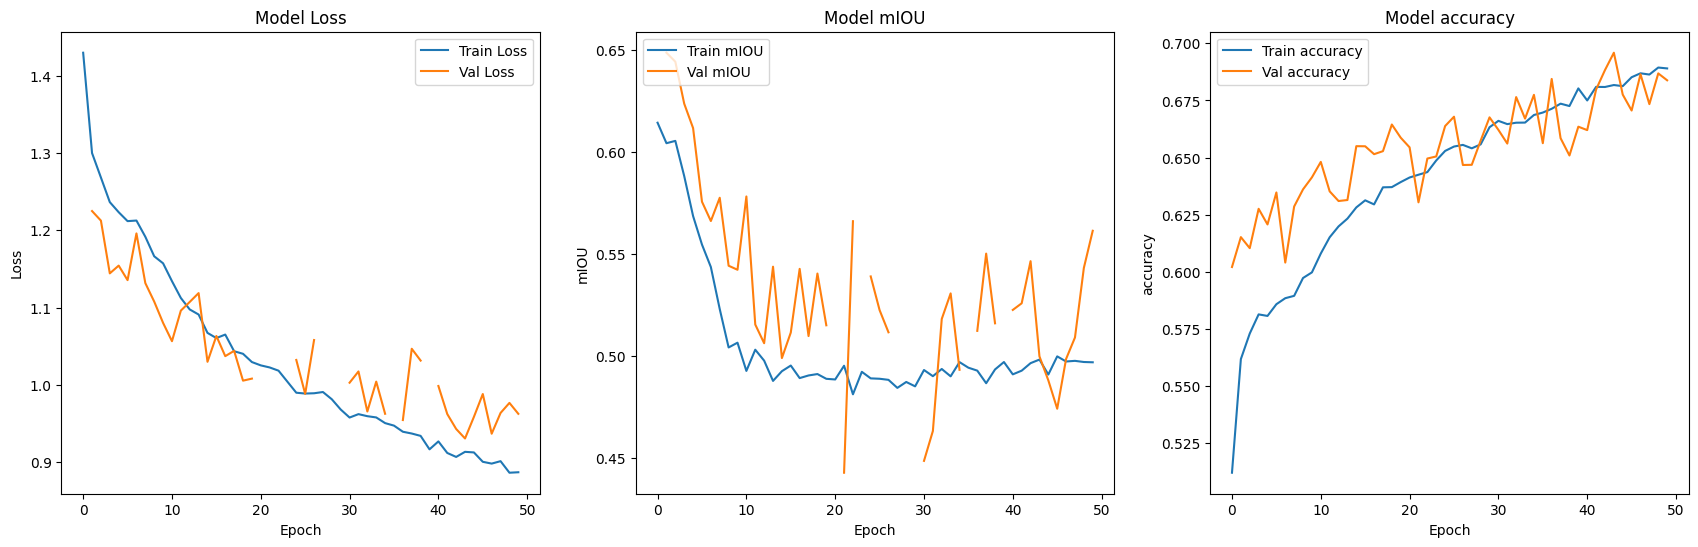

In [89]:
plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(history.history['mean_iou'], label='Train mIOU')
plt.plot(history.history['val_mean_iou'], label='Val mIOU')
plt.title('Model mIOU')
plt.xlabel('Epoch')
plt.ylabel('mIOU')
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.show()

In [121]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Mean IoU: {test_mean_iou}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.6800 - loss: 0.9216 - mean_iou: 0.4614
Test Loss: 0.9884249567985535, Test Accuracy: 0.6575497388839722, Test Mean IoU: 0.4611618220806122


## TA U-net

In [209]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [210]:
class TripletAttention(Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(TripletAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv1 = Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, padding='same')
        self.bn3 = BatchNormalization()

    def call(self, inputs):
        _, H, W, C = inputs.shape

        # Branch 1 (C, H)
        x1 = tf.transpose(inputs, [0, 3, 1, 2])
        x1_max = tf.reduce_max(x1, axis=1, keepdims=True)
        x1_mean = tf.reduce_mean(x1, axis=1, keepdims=True)
        x1 = tf.concat([x1_max, x1_mean], axis=1)
        x1 = tf.transpose(x1, [0, 2, 3, 1])
        x1 = self.conv1(x1)
        x1 = self.bn1(x1)
        x1 = Activation('sigmoid')(x1)

        # Branch 2 (C, W)
        x2 = tf.transpose(inputs, [0, 3, 2, 1])
        x2_max = tf.reduce_max(x2, axis=1, keepdims=True)
        x2_mean = tf.reduce_mean(x2, axis=1, keepdims=True)
        x2 = tf.concat([x2_max, x2_mean], axis=1)
        x2 = tf.transpose(x2, [0, 2, 3, 1])
        x2 = self.conv2(x2)
        x2 = self.bn2(x2)
        x2 = Activation('sigmoid')(x2)

        # Branch 3 (H, W)
        x3_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
        x3_mean = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        x3 = tf.concat([x3_max, x3_mean], axis=-1)
        x3 = self.conv3(x3)
        x3 = self.bn3(x3)
        x3 = Activation('sigmoid')(x3)

        # Combine branches
        out = (inputs * x1 + inputs * x2 + inputs * x3) / 3
        return out

In [211]:
def encoder_block(input_tensor, num_filters, use_attention=False):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if use_attention:
        x = TripletAttention()(x)
    
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

In [212]:
def decoder_block(input_tensor, skip_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, skip_tensor])
    
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [213]:
def TA_Unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 64, use_attention=False)
    s2, p2 = encoder_block(p1, 128, use_attention=True)
    s3, p3 = encoder_block(p2, 256, use_attention=True)
    s4, p4 = encoder_block(p3, 512, use_attention=True)
    
    # Bottleneck
    b1 = Conv2D(1024, (3, 3), padding='same')(p4)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)
    
    b1 = Conv2D(1024, (3, 3), padding='same')(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)
    
    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    # Output
    conv = Conv2D(8, (1, 1))(d4)
    outputs = tf.keras.layers.Softmax(axis=-1)(conv)
    
    model = Model(inputs, outputs)
    return model

In [216]:
model = TA_Unet(input_size=(128, 128, 3))
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', mean_iou])
model.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_645 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_645[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_443      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_646 (Conv2D) │ (None, 128, 128,  │     36,928 │ activation_443[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_646[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_444      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_114   │ (None, 64, 64,    │          0 │ activation_444[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_647 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_647[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_445      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_648 (Conv2D) │ (None, 64, 64,    │    147,584 │ activation_445[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_648[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_446      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triplet_attention_… │ (None, 64, 64,    │      8,832 │ activation_446[0… │
│ (TripletAttention)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_115   │ (None, 32, 32,    │          0 │ triplet_attentio… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_652 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_11

 Total params: 31,117,576 (118.70 MB)

 Trainable params: 31,100,424 (118.64 MB)

 Non-trainable params: 17,152 (67.00 KB)

In [217]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 123s 263ms/step - accuracy: 0.5329 - loss: 1.4450 - mean_iou: 0.4533 - val_accuracy: 0.1544 - val_loss: 4.9179 - val_mean_iou: 0.4784
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 86s 247ms/step - accuracy: 0.5776 - loss: 1.2435 - mean_iou: 0.4956 - val_accuracy: 0.6062 - val_loss: nan - val_mean_iou: nan
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 87s 249ms/step - accuracy: 0.5726 - loss: 1.2405 - mean_iou: 0.4954 - val_accuracy: 0.6233 - val_loss: nan - val_mean_iou: nan
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 87s 250ms/step - accuracy: 0.5965 - loss: 1.1842 - mean_iou: 0.4875 - val_accuracy: 0.5396 - val_loss: nan - val_mean_iou: nan
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 86s 246ms/step - accuracy: 0.6189 - loss: 1.1183 - mean_iou: 0.4875 - val_accuracy: 0.6350 - val_loss: 1.1486 - val_mean_iou: 0.5951
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 87s 249ms/step - accuracy: 0.6295 - loss: 1.1023 - mean_iou: 0.5157 - val_accuracy: 0.6527 - val_loss: 1.0419 - 

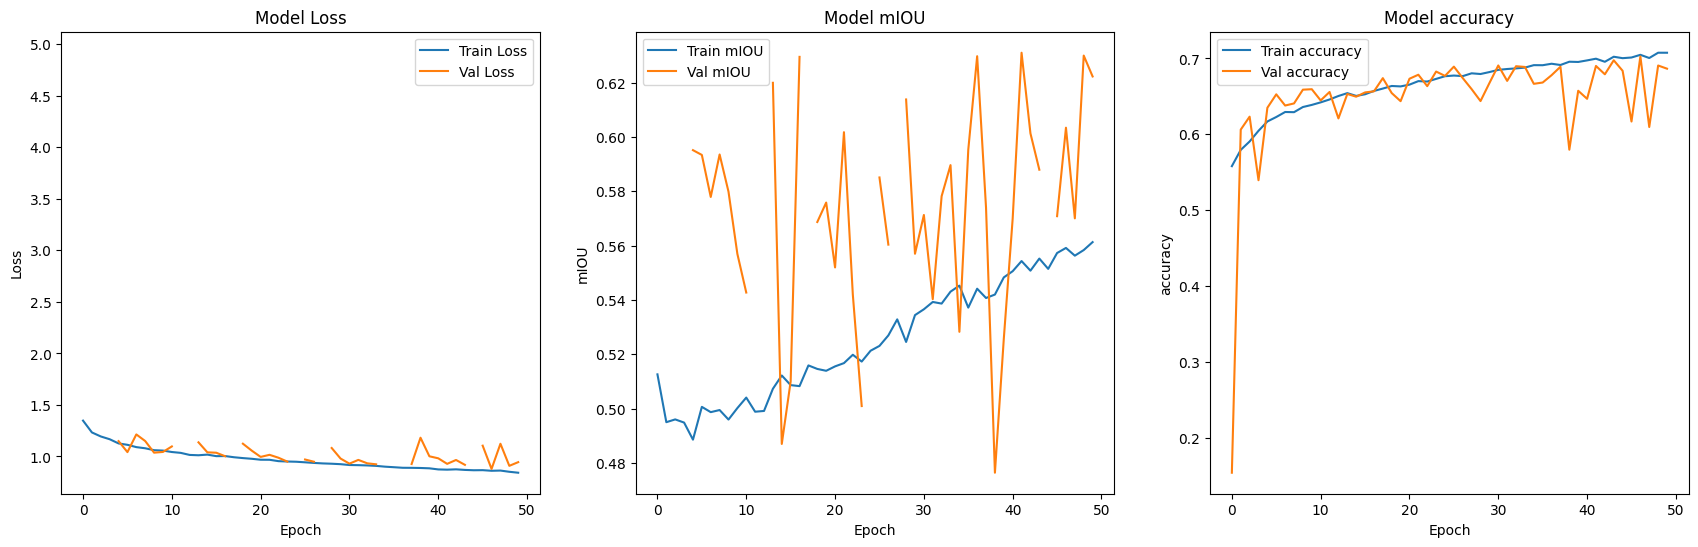

In [218]:
plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(history.history['mean_iou'], label='Train mIOU')
plt.plot(history.history['val_mean_iou'], label='Val mIOU')
plt.title('Model mIOU')
plt.xlabel('Epoch')
plt.ylabel('mIOU')
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.show()

In [219]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Mean IoU: {test_mean_iou}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.6751 - loss: 0.9550 - mean_iou: 0.5717
Test Loss: 1.0052603483200073, Test Accuracy: 0.6552527546882629, Test Mean IoU: 0.5453101396560669
